In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random
from PIL import Image, ImageEnhance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [6]:
train_dir="brain_tumor_dataset/Training"
test_dir="brain_tumor_dataset/Testing"

#load and shuffle the daata
train_paths=[]
train_labels=[]

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

#shuffle the data
train_paths,train_labels=shuffle(train_paths,train_labels)
print(train_paths)

['brain_tumor_dataset/Training\\glioma_tumor\\gg (478).jpg', 'brain_tumor_dataset/Training\\meningioma_tumor\\m (157).jpg', 'brain_tumor_dataset/Training\\meningioma_tumor\\m1(76).jpg', 'brain_tumor_dataset/Training\\pituitary_tumor\\p (302).jpg', 'brain_tumor_dataset/Training\\pituitary_tumor\\p (604).jpg', 'brain_tumor_dataset/Training\\no_tumor\\image(139).jpg', 'brain_tumor_dataset/Training\\glioma_tumor\\gg (821).jpg', 'brain_tumor_dataset/Training\\glioma_tumor\\gg (768).jpg', 'brain_tumor_dataset/Training\\pituitary_tumor\\p (296).jpg', 'brain_tumor_dataset/Training\\meningioma_tumor\\m (89).jpg', 'brain_tumor_dataset/Training\\meningioma_tumor\\m (163).jpg', 'brain_tumor_dataset/Training\\pituitary_tumor\\p (384).jpg', 'brain_tumor_dataset/Training\\glioma_tumor\\gg (390).jpg', 'brain_tumor_dataset/Training\\pituitary_tumor\\p (139).jpg', 'brain_tumor_dataset/Training\\meningioma_tumor\\m2 (163).jpg', 'brain_tumor_dataset/Training\\meningioma_tumor\\m1(56).jpg', 'brain_tumor_da

In [7]:
test_paths=[]
test_labels=[]

#shuffle the testing data

for label1 in os.listdir(test_dir):
    for image1 in os.listdir(os.path.join(test_dir,label1)):
        test_paths.append(os.path.join(test_dir,label1,image1))
        test_labels.append(label1)
test_paths,test_labels=shuffle(test_paths,test_labels)
print(test_paths)

['brain_tumor_dataset/Testing\\pituitary_tumor\\image(66).jpg', 'brain_tumor_dataset/Testing\\glioma_tumor\\image(9).jpg', 'brain_tumor_dataset/Testing\\glioma_tumor\\image(43).jpg', 'brain_tumor_dataset/Testing\\no_tumor\\image(45).jpg', 'brain_tumor_dataset/Testing\\meningioma_tumor\\image(23).jpg', 'brain_tumor_dataset/Testing\\glioma_tumor\\image(23).jpg', 'brain_tumor_dataset/Testing\\glioma_tumor\\image(52).jpg', 'brain_tumor_dataset/Testing\\pituitary_tumor\\image(88).jpg', 'brain_tumor_dataset/Testing\\glioma_tumor\\image(42).jpg', 'brain_tumor_dataset/Testing\\no_tumor\\image(44).jpg', 'brain_tumor_dataset/Testing\\pituitary_tumor\\image(13).jpg', 'brain_tumor_dataset/Testing\\meningioma_tumor\\image(25).jpg', 'brain_tumor_dataset/Testing\\pituitary_tumor\\image(52).jpg', 'brain_tumor_dataset/Testing\\glioma_tumor\\image(21).jpg', 'brain_tumor_dataset/Testing\\no_tumor\\image(50).jpg', 'brain_tumor_dataset/Testing\\glioma_tumor\\image(58).jpg', 'brain_tumor_dataset/Testing\\no

In [8]:
import matplotlib.pyplot as plt

#select random indcies fro 10 image
random_indices=random.sample(range(len(train_paths)),10)
print(random_indices)

[2532, 973, 884, 1254, 231, 1581, 1487, 383, 362, 2630]


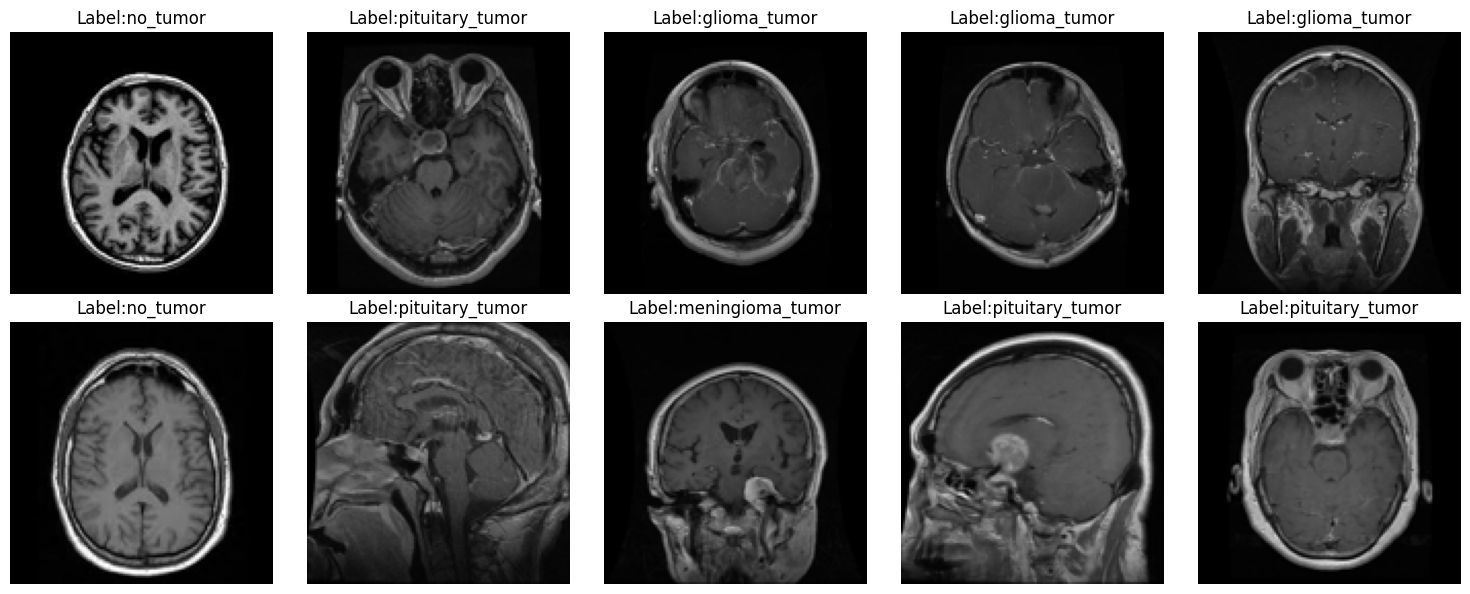

In [9]:
fig, axes= plt.subplots(2,5,figsize=(15,6))
axes=axes.ravel()

for i ,idx in enumerate(random_indices):
    img_paths=train_paths[idx]
    img=Image.open(img_paths)
    img=img.resize((128,128))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label:{train_labels[idx]}")
plt.tight_layout()
plt.show()


image preprocessing

In [24]:
#image augmentation function

def augment_image(image):
    image=Image.fromarray(np.uint8(image))
    image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image=ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image=np.array(image)/255.0
    return image
def open_images(paths):
    image=[]
    for path in paths:
        img=load_img(path,target_size=(IMAGE_SIZE,IMAGE_SIZE))
        img=augment_image(img)
        image.append(img)
    return np.array(image)


def datagen(paths, labels, batch_size=12):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_images(batch_paths)
            
            batch_labels = encode_label(labels[i:i+batch_size])  # ensure per-batch encoding
            
            yield np.array(batch_images), np.array(batch_labels)

def encode_label(batch_labels):
    label_map = {
        'glioma_tumor': 0,
        'meningioma_tumor': 1,
        'pituitary_tumor': 2,
        'no_tumor': 3
    }
    return np.array([label_map[l] for l in batch_labels])



In [28]:
#Model Architecture
IMAGE_SIZE=128
base_model=VGG16(input_shape=(128,128,3),include_top=False,weights="imagenet")

#freeze all layers
for layers in base_model.layers:
    layers.trainable=False
#set only last few layers
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

#build model
model=Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3)) #drop 30% neurons
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4,activation="softmax"))

#compile model
model.compile(optimizer=Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=['accuracy'])
batch_size=20
steps=int(len(train_paths)/batch_size)
epochs=5


X_batch, y_batch = next(datagen(train_paths, train_labels, batch_size=20))
print("Images shape:", X_batch.shape)
print("Labels shape:", y_batch.shape)
print("First 5 labels:", y_batch[:5])


#train model
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=len(train_paths)//batch_size
)



Images shape: (20, 128, 128, 3)
Labels shape: (20,)
First 5 labels: [0 1 1 2 2]
Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 928ms/step - accuracy: 0.6133 - loss: 0.9524
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 128s 896ms/step - accuracy: 0.8380 - loss: 0.4083
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 129s 900ms/step - accuracy: 0.8783 - loss: 0.3279
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 128s 898ms/step - accuracy: 0.9110 - loss: 0.2206
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 130s 906ms/step - accuracy: 0.9318 - loss: 0.1714


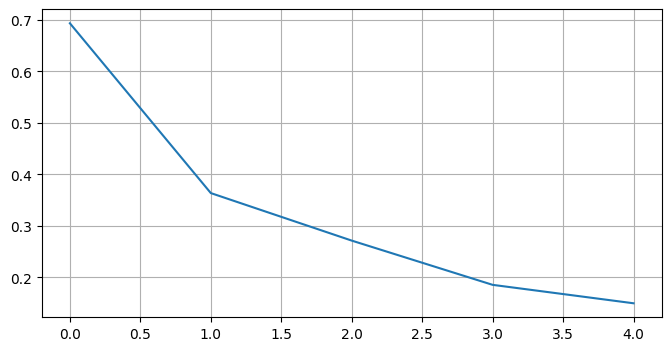

In [30]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['loss'])

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize

In [40]:
test_images=open_images(test_paths)
test_labels_encoded=encode_label(test_labels)
test_predictions=model.predict(test_images)

print("classifiction report")
print(classification_report(test_labels_encoded,np.argmax(test_predictions,axis=1)))


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
classifiction report
              precision    recall  f1-score   support

           0       0.94      0.15      0.26       100
           1       0.34      0.95      0.50        40
           2       1.00      0.54      0.70        74
           3       0.68      0.97      0.80       105

    accuracy                           0.61       319
   macro avg       0.74      0.65      0.56       319
weighted avg       0.79      0.61      0.57       319



In [44]:
conf_matrix=confusion_matrix(test_labels_encoded, np.argmax(test_predictions,axis=1))
print("confusion matrix")
print(conf_matrix)

confusion matrix
[[ 15  53   0  32]
 [  0  38   0   2]
 [  1  19  40  14]
 [  0   3   0 102]]


Text(158.08159722222223, 0.5, 'True')

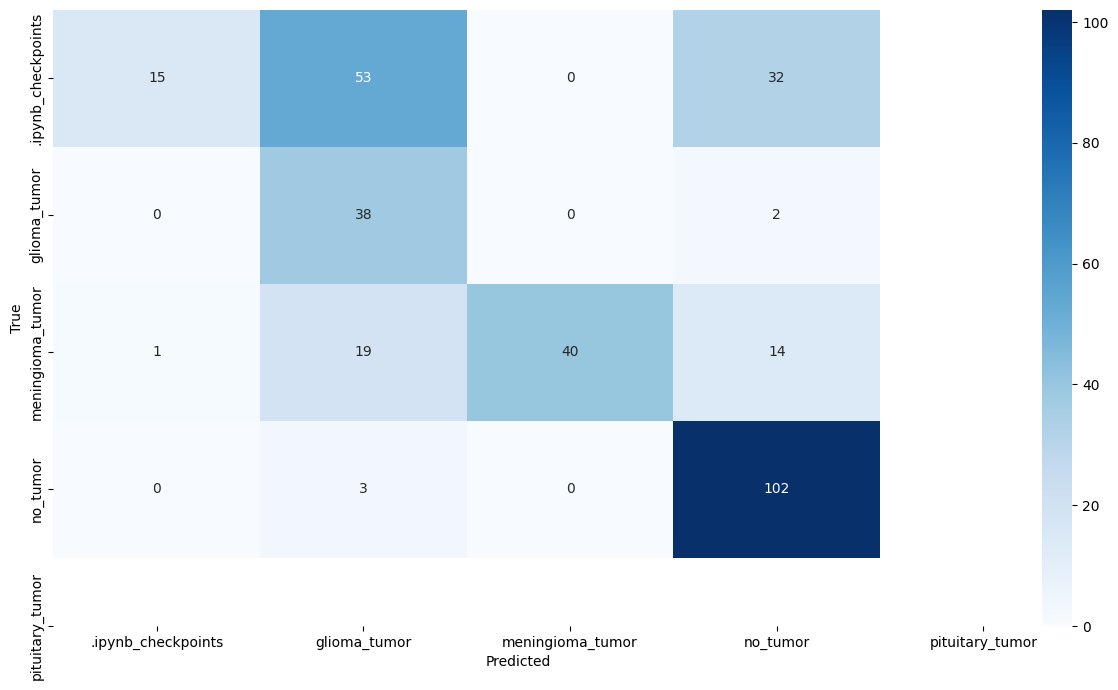

In [48]:
plt.figure(figsize=(15,8))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap="Blues",xticklabels=os.listdir(train_dir),yticklabels=os.listdir(test_dir))
plt.xlabel("Predicted")
plt.ylabel("True")

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


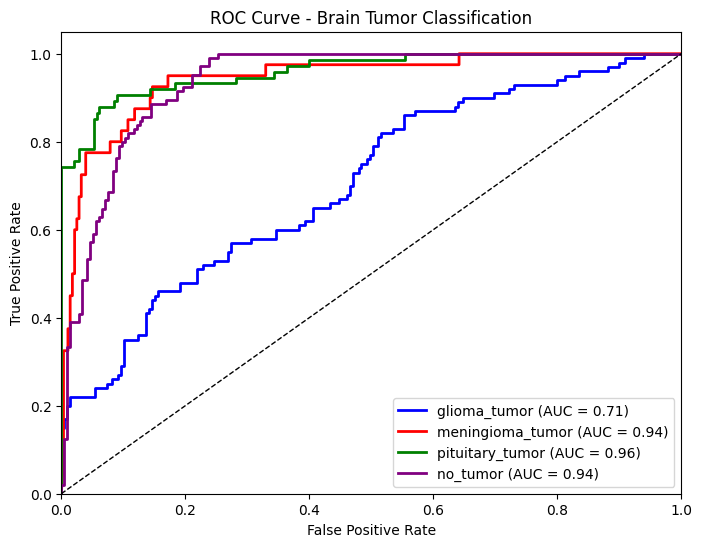

In [50]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Encode and Binarize labels ---
label_names = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

test_labels_encoded = encode_label(test_labels)
y_test_bin = label_binarize(test_labels_encoded, classes=[0, 1, 2, 3])

# --- Step 2: Get model predictions ---
y_score = model.predict(test_images)   # shape = (n_samples, 4)

# --- Step 3: Compute ROC curve and AUC for each class ---
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Step 4: Plot ROC curves ---
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f'{label_names[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Brain Tumor Classification')
plt.legend(loc='lower right')
plt.show()


In [52]:
#save the entire model
model.save("model.h5")

In [54]:
#load the model for testing

from tensorflow.keras.models import load_model
model=load_model('model.h5')

MRI Tumor Detection System

In [93]:
from keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(image_path, model):
    try:
        # Load and preprocess image
        img = load_img(image_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions)
        confidence_score = np.max(predictions)

        # Determine class
        predicted_label = class_labels[predicted_class_index]
        if predicted_label == 'notumor':
            result = "No Tumor Detected"
        else:
            result = f"Tumor Detected: {predicted_label}"

        # Display image with prediction
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Exception is:", e)

        
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


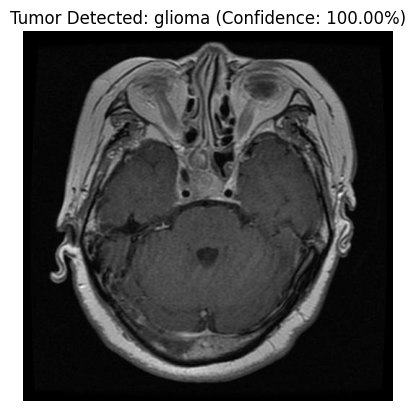

In [99]:
image_path="brain_tumor_dataset/Training/pituitary_tumor/p (7).jpg"
detect_and_display(image_path,model)